# Penjadwalan Kuliah dengan Algoritma Genetika
Notebook ini menyusun jadwal kuliah multi-kelas menggunakan pendekatan Genetic Algorithm (GA).


## Konteks dan aturan singkat
- Jadwal untuk semester 1, 3, 5, dan 7; masing-masing memiliki kelas A dan B.
- Hari kuliah: Senin?Sabtu, jam 07.00?17.00 dengan slot 50 menit (12 slot per hari).
- Ruang tersedia: TI1?TI6; satu ruang hanya untuk satu mata kuliah pada slot yang sama.
- Dosen luar biasa hanya boleh mengajar Jumat atau Sabtu.
- GA: populasi kromosom (jadwal), seleksi, crossover, mutasi; fitness menghukum benturan ruangan/dosen/kelas, pelanggaran dosen luar biasa, dan ketidakselarasan durasi SKS.


## Format file `mata_kuliah.csv`
Kolom wajib: `kode_mk, nama_mk, semester, kelas, dosen, tipe_dosen, sks`.
Contoh baris:

```
kode_mk,nama_mk,semester,kelas,dosen,tipe_dosen,sks
TI101,Kalkulus I,1,A,Dr. A,Tetap,3
TI103,Pengantar TI,1,B,Ir. B,LuarBiasa,2
TI203,Struktur Data,3,A,Dr. C,Tetap,3
```
Jika file tidak ditemukan, notebook menampilkan pesan dan memakai data sampel agar sel tetap dapat dieksekusi.


In [68]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from pathlib import Path
from collections import defaultdict
from typing import List, Dict, Tuple

plt.style.use("ggplot")
random.seed(42)
np.random.seed(42)


In [69]:
DAYS = ["Senin", "Selasa", "Rabu", "Kamis", "Jumat", "Sabtu"]
ROOMS = [f"TI{i}" for i in range(1, 7)]
SLOT_DURATION = 50  # menit

def build_time_slots(start_hour: int = 7, start_minute: int = 0, num_slots: int = 12, duration: int = 50):
    slots = []
    hour = start_hour
    minute = start_minute
    for idx in range(num_slots):
        end_minute = minute + duration
        end_hour = hour + end_minute // 60
        end_minute = end_minute % 60
        slots.append({
            "index": idx,
            "jam_mulai": f"{hour:02d}:{minute:02d}",
            "jam_selesai": f"{end_hour:02d}:{end_minute:02d}",
        })
        hour, minute = end_hour, end_minute
    return slots

TIME_SLOTS = build_time_slots()
TIME_SLOTS[:3]


[{'index': 0, 'jam_mulai': '07:00', 'jam_selesai': '07:50'},
 {'index': 1, 'jam_mulai': '07:50', 'jam_selesai': '08:40'},
 {'index': 2, 'jam_mulai': '08:40', 'jam_selesai': '09:30'}]

In [70]:
REQUIRED_COLUMNS = [
    "kode_mk",
    "nama_mk",
    "semester",
    "kelas",
    "dosen",
    "tipe_dosen",
    "sks",
]


def expand_class_rows(df: pd.DataFrame) -> pd.DataFrame:
    # Duplikasi baris jika kolom kelas berisi beberapa kelas (misal "A,B").
    rows = []
    for _, row in df.iterrows():
        kelas_raw = str(row.get("kelas", "") or "").strip()
        tokens = [k.strip() for k in kelas_raw.replace(";", ",").replace("/", ",").split(",") if k.strip()]
        kelas_list = tokens or ([kelas_raw] if kelas_raw else ["A"])
        for kelas in kelas_list:
            new_row = row.copy()
            new_row["kelas"] = kelas
            rows.append(new_row)
    return pd.DataFrame(rows).reset_index(drop=True)


def clean_columns(df: pd.DataFrame) -> pd.DataFrame:
    # Hilangkan kolom tanpa nama dan rapikan header yang mungkin salah ketik.
    df = df.loc[:, ~df.columns.str.startswith("Unnamed")]
    if "jenis_dosen" in df.columns and "tipe_dosen" not in df.columns:
        df = df.rename(columns={"jenis_dosen": "tipe_dosen"})
    return df


def read_course_data(path: str = "Daftar_Mata_Kuliah_Lengkap.csv", alt_path: str = "Daftar_Mata_Kuliah_Lengkap.xlsx") -> pd.DataFrame:
    # Gunakan alt_path jika file utama tidak ada.
    path_to_use = path
    if not Path(path).exists() and Path(alt_path).exists():
        path_to_use = alt_path

    try:
        df = pd.read_excel(path_to_use, engine="openpyxl")
    except FileNotFoundError:
        print(f"File {path_to_use} tidak ditemukan, pastikan file berada di direktori yang sama dengan notebook.")
        return None
    except Exception as exc:
        print(f"Gagal membaca {path_to_use} sebagai Excel ({exc}). Mencoba membaca sebagai CSV...")
        try:
            df = pd.read_csv(path_to_use)
        except Exception as csv_exc:
            print(f"Gagal membaca {path_to_use} sebagai CSV ({csv_exc}).")
            return None

    df = clean_columns(df)
    df = expand_class_rows(df)
    missing = [c for c in REQUIRED_COLUMNS if c not in df.columns]
    if missing:
        raise ValueError(f"Kolom wajib hilang: {missing}")
    return df


def make_sample_courses() -> pd.DataFrame:
    data = [
        {"kode_mk": "TI101", "nama_mk": "Kalkulus I", "semester": 1, "kelas": "A", "dosen": "Dr. A", "tipe_dosen": "Tetap", "sks": 3},
        {"kode_mk": "TI101", "nama_mk": "Kalkulus I", "semester": 1, "kelas": "B", "dosen": "Dr. A", "tipe_dosen": "Tetap", "sks": 3},
        {"kode_mk": "TI102", "nama_mk": "Aljabar Linear", "semester": 1, "kelas": "A", "dosen": "Dr. B", "tipe_dosen": "Tetap", "sks": 3},
        {"kode_mk": "TI102", "nama_mk": "Aljabar Linear", "semester": 1, "kelas": "B", "dosen": "Dr. B", "tipe_dosen": "Tetap", "sks": 3},
        {"kode_mk": "TI103", "nama_mk": "Pengantar TI", "semester": 1, "kelas": "A", "dosen": "Ir. C", "tipe_dosen": "LuarBiasa", "sks": 2},
        {"kode_mk": "TI104", "nama_mk": "Logika Informatika", "semester": 1, "kelas": "B", "dosen": "Ir. D", "tipe_dosen": "Tetap", "sks": 2},
        {"kode_mk": "TI201", "nama_mk": "Struktur Data", "semester": 3, "kelas": "A", "dosen": "Dr. E", "tipe_dosen": "Tetap", "sks": 3},
        {"kode_mk": "TI201", "nama_mk": "Struktur Data", "semester": 3, "kelas": "B", "dosen": "Dr. E", "tipe_dosen": "Tetap", "sks": 3},
        {"kode_mk": "TI202", "nama_mk": "Sistem Operasi", "semester": 3, "kelas": "A", "dosen": "Dr. F", "tipe_dosen": "Tetap", "sks": 3},
        {"kode_mk": "TI202", "nama_mk": "Sistem Operasi", "semester": 3, "kelas": "B", "dosen": "Dr. F", "tipe_dosen": "Tetap", "sks": 3},
    ]
    return pd.DataFrame(data)


data_mk = read_course_data("Daftar_Mata_Kuliah_Lengkap.csv")
if data_mk is None:
    data_mk = make_sample_courses()
    print(f"Data sampel digunakan sebanyak {len(data_mk)} mata kuliah.")
else:
    print(f"Berhasil memuat {len(data_mk)} mata kuliah dari file.")


data_mk.head()




Gagal membaca Daftar_Mata_Kuliah_Lengkap.csv sebagai Excel (File is not a zip file). Mencoba membaca sebagai CSV...
Berhasil memuat 54 mata kuliah dari file.


,semester,kode_mk,nama_mk,sks,dosen,kelas,tipe_dosen
0,1,MKI112206,Agama Kristen Protestan,2,"Pdt. Dr. Kilat Kasanang, S.Pd., M.Th.",A,DLB
1,1,MKI112204,Agama Hindu,2,"Dr. I. Gede Dharman Gunawan, M.Pd.H.",A,DLB
2,1,MKI112201,Agama Islam,2,"Drs. Heri Purwanto, M.Pd.",A,Tetap
3,1,MKI112201,Agama Islam,2,"Drs. Heri Purwanto, M.Pd.",B,Tetap
4,1,MKI112203,Agama Katolik,2,"Yustinus Dwi Andriyanto, S.Ag., M.M.",A,DLB


In [71]:
def get_course_list(course_data) -> List[Dict]:
    return course_data if isinstance(course_data, list) else course_data.to_dict("records")


def is_dlb(course: Dict) -> bool:
    tipe = str(course.get("tipe_dosen", "")).lower()
    return tipe in {"luarbiasa", "dlb", "dosen luar biasa", "dosenluarbiasa"}


def random_day_for(course: Dict) -> int:
    allowed_days = [4, 5] if is_dlb(course) else list(range(len(DAYS)))
    return random.choice(allowed_days)


def random_gene(course_idx: int, courses: List[Dict]) -> Dict:
    course = courses[course_idx]
    sks = int(course["sks"])
    max_start = len(TIME_SLOTS) - sks
    start_slot = random.randint(0, max_start)
    day = random_day_for(course)
    room = random.choice(ROOMS)
    return {
        "course_idx": course_idx,
        "day": day,
        "start_slot": start_slot,
        "room": room,
    }


def random_chromosome(courses: List[Dict]) -> List[Dict]:
    return [random_gene(i, courses) for i in range(len(courses))]


def init_population(pop_size: int, courses: List[Dict]) -> List[List[Dict]]:
    return [random_chromosome(courses) for _ in range(pop_size)]


def decode_chromosome(chromosome: List[Dict], course_data) -> pd.DataFrame:
    courses = get_course_list(course_data)
    rows = []
    for gene in chromosome:
        course = courses[gene["course_idx"]]
        sks = int(course["sks"])
        start_slot = gene["start_slot"]
        end_slot = start_slot + sks - 1
        start_time = TIME_SLOTS[start_slot]["jam_mulai"] if start_slot < len(TIME_SLOTS) else "?"
        end_time = TIME_SLOTS[end_slot]["jam_selesai"] if end_slot < len(TIME_SLOTS) else "?"
        rows.append({
            "hari": DAYS[gene["day"]],
            "hari_index": gene["day"],
            "slot_mulai": start_slot,
            "slot_selesai": end_slot,
            "jam_mulai": start_time,
            "jam_selesai": end_time,
            "ruang": gene["room"],
            "kode_mk": course["kode_mk"],
            "nama_mk": course["nama_mk"],
            "semester": course["semester"],
            "kelas": course["kelas"],
            "dosen": course["dosen"],
            "tipe_dosen": course["tipe_dosen"],
            "sks": sks,
        })
    return pd.DataFrame(rows)



## Skema fitness
Fitness diukur sebagai `fitness = base_score - total_penalti` (tidak kurang dari 0).
Penalti yang digunakan:
- Benturan ruangan, dosen, dan kelas (semester+kelas) pada hari+slot yang sama.
- Dosen luar biasa mengajar di Senin?Kamis (penalti besar).
- Durasi tidak pas dengan SKS, slot melewati batas harian, atau tidak kontigu.
- Penalti ringan bila beban satu kelas per hari melewati 8 SKS (opsional soft-constraint).
Angka bobot dapat diubah sesuai kebutuhan.


In [72]:
def compute_penalty(chromosome: List[Dict], courses: List[Dict]) -> float:
    penalty = 0
    room_usage = defaultdict(list)
    lecturer_usage = defaultdict(list)
    class_usage = defaultdict(list)
    load_usage = defaultdict(int)

    for gene in chromosome:
        course = courses[gene["course_idx"]]
        sks = int(course["sks"])
        day = gene["day"]
        start_slot = gene["start_slot"]
        end_slot = start_slot + sks - 1
        room = gene["room"]
        dosen = course["dosen"]
        kelas = (course["semester"], course["kelas"])

        if start_slot < 0 or end_slot >= len(TIME_SLOTS):
            penalty += 3000
            continue

        slots = list(range(start_slot, start_slot + sks))
        for idx in range(len(slots) - 1):
            if slots[idx + 1] - slots[idx] != 1:
                penalty += 3000
                break

        for slot in slots:
            room_usage[(day, slot, room)].append(course["kode_mk"])
            lecturer_usage[(day, slot, dosen)].append(course["kode_mk"])
            class_usage[(day, slot, kelas)].append(course["kode_mk"])

        if is_dlb(course) and day not in (4, 5):
            penalty += 50000

        load_usage[(day, kelas)] += sks

    for usage in room_usage.values():
        if len(usage) > 1:
            penalty += (len(usage) - 1) * 1200
    for usage in lecturer_usage.values():
        if len(usage) > 1:
            penalty += (len(usage) - 1) * 1200
    for usage in class_usage.values():
        if len(usage) > 1:
            penalty += (len(usage) - 1) * 1200

    for (day, kelas), beban in load_usage.items():
        if beban > 8:
            penalty += (beban - 8) * 10

    return penalty


def fitness(chromosome: List[Dict], courses: List[Dict], base_score: float | None = None) -> float:
    if base_score is None:
        base_score = max(10000.0, len(courses) * 2000.0)
    return max(0.0, base_score - compute_penalty(chromosome, courses))



In [73]:
def evaluate_population(population: List[List[Dict]], courses: List[Dict]) -> Tuple[List[float], float]:
    fitness_values = [fitness(chrom, courses) for chrom in population]
    return fitness_values, float(sum(fitness_values))


def roulette_selection(population: List[List[Dict]], fitness_values: List[float], total_fit: float) -> List[Dict]:
    if total_fit <= 0:
        return random.choice(population)
    pick = random.uniform(0, total_fit)
    current = 0.0
    for chrom, fit in zip(population, fitness_values):
        current += fit
        if current >= pick:
            return chrom
    return population[-1]


def tournament_selection(population: List[List[Dict]], fitness_values: List[float], tournament_size: int = 3) -> List[Dict]:
    idxs = random.sample(range(len(population)), k=min(tournament_size, len(population)))
    best_idx = max(idxs, key=lambda idx: fitness_values[idx])
    return population[best_idx]


def one_point_crossover(parent1: List[Dict], parent2: List[Dict]) -> Tuple[List[Dict], List[Dict]]:
    if len(parent1) <= 1:
        return parent1.copy(), parent2.copy()
    point = random.randint(1, len(parent1) - 1)
    child1 = parent1[:point] + parent2[point:]
    child2 = parent2[:point] + parent1[point:]
    return child1, child2


def mutate(chromosome: List[Dict], courses: List[Dict], mutation_rate: float = 0.1) -> List[Dict]:
    new_chrom = []
    for gene in chromosome:
        if random.random() < mutation_rate:
            course = courses[gene["course_idx"]]
            sks = int(course["sks"])
            max_start = len(TIME_SLOTS) - sks
            mutate_choice = random.choice(["day", "slot", "room"])
            if mutate_choice == "day":
                gene = {**gene, "day": random_day_for(course)}
            elif mutate_choice == "slot":
                gene = {**gene, "start_slot": random.randint(0, max_start)}
            else:
                gene = {**gene, "room": random.choice(ROOMS)}
        new_chrom.append(gene)
    return new_chrom



In [74]:
def simple_ga(course_df: pd.DataFrame, population_size: int = 80, num_generations: int = 100, crossover_rate: float = 0.8, mutation_rate: float = 0.1):
    courses = get_course_list(course_df)
    population = init_population(population_size, courses)
    history = []
    best = None
    best_fitness = -1

    for gen in range(num_generations):
        fitness_values, total_fit = evaluate_population(population, courses)
        best_idx = int(np.argmax(fitness_values))
        best_gen_fit = fitness_values[best_idx]
        history.append(best_gen_fit)
        if best_gen_fit > best_fitness:
            best_fitness = best_gen_fit
            best = population[best_idx]

        new_population = []
        while len(new_population) < population_size:
            parent1 = roulette_selection(population, fitness_values, total_fit)
            parent2 = roulette_selection(population, fitness_values, total_fit)
            if random.random() < crossover_rate:
                child1, child2 = one_point_crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            child1 = mutate(child1, courses, mutation_rate)
            child2 = mutate(child2, courses, mutation_rate)
            new_population.extend([child1, child2])
        population = new_population[:population_size]
    return best, best_fitness, history


def elitism_ga(course_df: pd.DataFrame, population_size: int = 80, num_generations: int = 100, crossover_rate: float = 0.8, mutation_rate: float = 0.1, elitism_rate: float = 0.05):
    courses = get_course_list(course_df)
    population = init_population(population_size, courses)
    history = []
    elite_count = max(1, int(elitism_rate * population_size))
    best = None
    best_fitness = -1

    for gen in range(num_generations):
        fitness_values, total_fit = evaluate_population(population, courses)
        scored_pop = sorted(zip(fitness_values, population), key=lambda x: x[0], reverse=True)
        sorted_pop = [chrom for _, chrom in scored_pop]
        elites = sorted_pop[:elite_count]
        best_gen_fit = scored_pop[0][0]
        history.append(best_gen_fit)

        if best_gen_fit > best_fitness:
            best_fitness = best_gen_fit
            best = sorted_pop[0]

        new_population = elites.copy()
        while len(new_population) < population_size:
            parent1 = roulette_selection(population, fitness_values, total_fit)
            parent2 = roulette_selection(population, fitness_values, total_fit)
            if random.random() < crossover_rate:
                child1, child2 = one_point_crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            child1 = mutate(child1, courses, mutation_rate)
            child2 = mutate(child2, courses, mutation_rate)
            new_population.extend([child1, child2])
        population = new_population[:population_size]
    return best, best_fitness, history


def tournament_ga(course_df: pd.DataFrame, population_size: int = 80, num_generations: int = 100, crossover_rate: float = 0.8, mutation_rate: float = 0.1, tournament_size: int = 3):
    courses = get_course_list(course_df)
    population = init_population(population_size, courses)
    history = []
    best = None
    best_fitness = -1

    for gen in range(num_generations):
        fitness_values, _ = evaluate_population(population, courses)
        best_idx = int(np.argmax(fitness_values))
        gen_best = fitness_values[best_idx]
        history.append(gen_best)
        if gen_best > best_fitness:
            best_fitness = gen_best
            best = population[best_idx]

        new_population = []
        while len(new_population) < population_size:
            parent1 = tournament_selection(population, fitness_values, tournament_size)
            parent2 = tournament_selection(population, fitness_values, tournament_size)
            if random.random() < crossover_rate:
                child1, child2 = one_point_crossover(parent1, parent2)
            else:
                child1, child2 = parent1.copy(), parent2.copy()
            child1 = mutate(child1, courses, mutation_rate)
            child2 = mutate(child2, courses, mutation_rate)
            new_population.extend([child1, child2])
        population = new_population[:population_size]
    return best, best_fitness, history



In [75]:
def run_ga(
    course_df: pd.DataFrame,
    method: str = "simple_ga",
    population_size: int = 100,
    num_generations: int = 150,
    crossover_rate: float = 0.85,
    mutation_rate: float = 0.1,
    elitism_rate: float = 0.05,
    tournament_size: int = 3,
):
    if method == "simple_ga":
        return simple_ga(course_df, population_size, num_generations, crossover_rate, mutation_rate)
    if method == "elitism_ga":
        return elitism_ga(course_df, population_size, num_generations, crossover_rate, mutation_rate, elitism_rate)
    if method == "tournament_ga":
        return tournament_ga(course_df, population_size, num_generations, crossover_rate, mutation_rate, tournament_size)
    raise ValueError("Metode GA tidak dikenali")


best_chromosome, best_score, history = run_ga(
    data_mk,
    method="elitism_ga",
    population_size=120,
    num_generations=120,
    crossover_rate=0.9,
    mutation_rate=0.15,
    elitism_rate=0.08,
    tournament_size=3,
)

print(f"Fitness terbaik: {best_score:.2f}")


Fitness terbaik: 104380.00


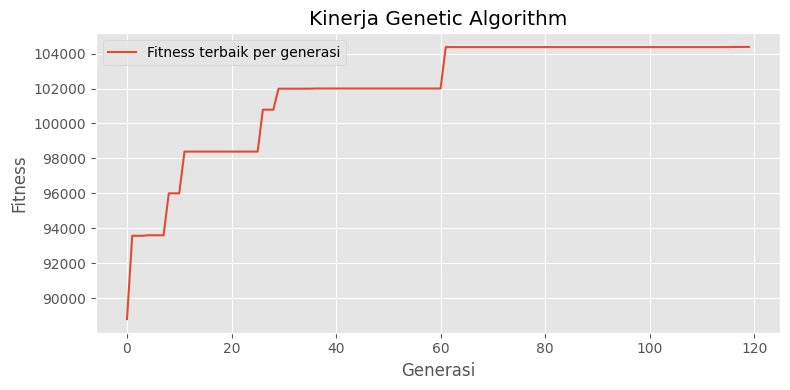

,hari,hari_index,slot_mulai,slot_selesai,jam_mulai,jam_selesai,ruang,kode_mk,nama_mk,semester,kelas,dosen,tipe_dosen,sks
0,Senin,0,0,2,07:00,09:30,TI2,MKJ512301,Sistem Terdistribusi,5,B,"Herkules, S.Kom., M.Cs.",Tetap,3
1,Senin,0,0,1,07:00,08:40,TI6,MKI112201,Agama Islam,1,B,"Drs. Heri Purwanto, M.Pd.",Tetap,2
2,Senin,0,1,1,07:50,08:40,TI1,RPL312101,Praktikum Sistem Basis Data,3,B,"Rommi Kaestira, M.Kom.",Tetap,1
3,Senin,0,2,4,08:40,11:10,TI3,RPL312305,Pemrograman Web,3,A,"Lili Rusdiana, M.Kom.",Tetap,3
4,Senin,0,3,3,09:30,10:20,TI4,ARK312101,Praktikum Sistem Operasi,3,B,"Amaya Andri Damaini, S.Kom., M.T.",Tetap,1
5,Senin,0,3,4,09:30,11:10,TI6,MKI312207,Pendidikan Anti Korupsi,3,B,"Drs. Heri Purwanto, M.Pd.",Tetap,2
6,Senin,0,4,6,10:20,12:50,TI6,GKM712301,Pemodelan dan Simulasi,7,B,"Hotmian Sitohang, M.Kom.",Tetap,3
7,Senin,0,5,6,11:10,12:50,TI4,MKH112201,Bahasa Inggris I,1,B,"Catharina Elmayantie, M.Pd.",Tetap,2
8,Senin,0,6,8,12:00,14:30,TI5,RPL512203,Pemrograman Framework,5,A,"Christia Putra, S.Kom., M.MSI./Abdi Dwi Nugrah...",Tetap,3
9,Senin,0,8,10,13:40,16:10,TI4,CDS512301,Sistem Pengambilan Keputusan,5,B,"Veny Cahya Hardita, M.Kom.",Tetap,3


In [76]:
plt.figure(figsize=(8, 4))
plt.plot(history, label="Fitness terbaik per generasi")
plt.xlabel("Generasi")
plt.ylabel("Fitness")
plt.title("Kinerja Genetic Algorithm")
plt.legend()
plt.tight_layout()
plt.show()

jadwal_terbaik_df = decode_chromosome(best_chromosome, data_mk)
jadwal_terbaik_df = jadwal_terbaik_df.sort_values(["hari_index", "slot_mulai", "ruang"]).reset_index(drop=True)
jadwal_terbaik_df


In [77]:
output_file = "jadwal_terbaik.csv"
jadwal_terbaik_df.to_csv(output_file, index=False)
print(f"Jadwal terbaik disimpan ke {output_file}")


Jadwal terbaik disimpan ke jadwal_terbaik.csv


## Kapan memilih tiap metode GA?
- `simple_ga`: baseline simpel, cocok untuk eksperimen awal atau populasi besar dengan komputasi ringan.
- `elitism_ga`: gunakan ketika ingin menjaga individu unggul agar tidak hilang; baik saat fitness fluktuatif.
- `tournament_ga`: cocok bila ingin tekanan seleksi lebih kuat/terkendali lewat `tournament_size`; efektif di landscape fitness yang datar.
